# **Face Recognition Model Comparison: Analyzing Performance of Multiple Architectures**

In this notebook, we explore and compare various deep learning architectures for face recognition. The goal is to train and evaluate five different models to identify the best-performing architecture for the LFWPeople dataset. We utilize a combination of well-known models, including **FaceNet (ResNet50), FaceNet (InceptionResnetV1), ArcFace, VGGFace, and Dlib**.

Throughout this analysis, each model is configured with techniques to improve accuracy, including cross-entropy with label smoothing, dynamic learning rate scheduling, and early stopping to mitigate overfitting.

In this Kaggle notebook, **each version presents unique setups** for the models, experimenting with different network layers, training configurations, and regularization strategies. This approach allows us to refine model performance and compare outcomes from varied architectures and optimization techniques across versions. Explore the latest approaches in other versions of this [notebook](https://www.kaggle.com/code/samiraalipour/facerecognition-facenet-arcface-vggface-dlib) to see alternative setups and their impact on model accuracy and generalization.

In [ ]:
# Install required packages
!pip install torchviz

In [ ]:
!pip install facenet-pytorch dlib face_recognition torch torchvision timm

In [4]:
import os
import bz2
import shutil
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import threading
import torch.nn.functional as F
import torchvision.models as models
from torchviz import make_dot
from torchvision.utils import make_grid
from IPython.display import Image
from facenet_pytorch import InceptionResnetV1

import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Function to download files with progress bar
def download_file(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    
    with open(filename, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

# Function to extract bz2 files
def extract_bz2(filename):
    print(f"Extracting {filename}...")
    with bz2.BZ2File(filename, 'rb') as source, open(filename[:-4], 'wb') as dest:
        shutil.copyfileobj(source, dest)
    os.remove(filename)  # Remove the compressed file
    print(f"Extracted {filename}")

# Download and extract required Dlib models
def setup_dlib_models():
    models = {
        'dlib_face_recognition_resnet_model_v1.dat': 
            'http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2',
        'shape_predictor_68_face_landmarks.dat': 
            'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    }
    
    for model_name, url in models.items():
        if not os.path.exists(model_name):
            print(f"Downloading {model_name}...")
            compressed_file = f"{model_name}.bz2"
            download_file(url, compressed_file)
            extract_bz2(compressed_file)
        else:
            print(f"{model_name} already exists.")


## **Dataset Preparation**

To train models, a dataset of face images with labels for each individual is prepared, followed by a split into training and validation sets to ensure balanced evaluation:

1. **Data Augmentation for Training Set**: Advanced data augmentation techniques are applied to the training set to enhance model robustness. The transformations include:

   - Resizing to 256x256 followed by random cropping to 224x224, which enhances scale invariance
   - Random affine transformations now include scaling (0.9 to 1.1) in addition to translation
   - Occasional application of Gaussian blur (p=0.2) to simulate focus variations
   - Random grayscale conversion (p=0.1) to improve robustness to color information
   - Random erasing (p=0.1) to help the model focus on multiple facial features and simulate partial occlusions
   
      These advanced augmentations create an even more diverse set of training samples, mimicking a wider range of real-world conditions and potential variations in face images.

2. **Transformations for Validation Set**: For validation, only basic resizing and normalization transformations are applied. No augmentation is used on the validation set, preserving the original data distribution for accurate performance evaluation.
   - Images are first resized to 256x256
   - A center crop of 224x224 is then applied, ensuring a consistent input size matching the training set

3. **Splitting by Person ID**: To maintain class balance, the data is split by person ID. For individuals with multiple images, samples are divided into training and validation subsets to allow for a balanced evaluation. If a person has only one image, that sample is added to the training set to maximize the training data.

4. **Data Loaders**: Finally, `train_loader` and `val_loader` objects are created to handle batching and shuffling of the training and validation datasets. This setup improves efficiency during the training and evaluation process.



In [6]:
def prepare_data():
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.RandomCrop(224),     # Random crop for better generalization
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1)  # Randomly erase parts of the image
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the LFW dataset with different transformations for training and validation sets
    lfw_dataset_train = datasets.LFWPeople(root='./data', download=True, transform=train_transforms)
    lfw_dataset_val = datasets.LFWPeople(root='./data', download=True, transform=val_transforms)

    # Extract labels from the dataset
    labels = [label for _, label in lfw_dataset_train]

    # Organize data by person ID
    person_to_indices = {}
    for idx, label in enumerate(labels):
        if label not in person_to_indices:
            person_to_indices[label] = []
        person_to_indices[label].append(idx)

    # Split each person's images into train/val sets
    train_indices = []
    val_indices = []
    for person, indices in person_to_indices.items():
        if len(indices) > 1:
            # If a person has more than one image, split them between training and validation
            train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
            train_indices.extend(train_idx)
            val_indices.extend(val_idx)
        else:
            # If a person has only one image, put it in the training set
            train_indices.extend(indices)

    # Create Subsets for training and validation
    train_dataset = torch.utils.data.Subset(lfw_dataset_train, train_indices)
    val_dataset = torch.utils.data.Subset(lfw_dataset_val, val_indices)

    # Create DataLoader objects
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True,
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32, 
        shuffle=False,
        num_workers=2,  
        pin_memory=True
    )
    
    # Show the sample data with improved formatting
    show_sample_data(train_loader, lfw_dataset_train)

    return train_loader, val_loader, len(lfw_dataset_train.class_to_idx)

In [7]:
def show_sample_data(loader, dataset, num_images=8, rows=2):

    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Calculate columns based on number of images and rows
    cols = num_images // rows
    
    # Create image grid with increased padding
    img_grid = make_grid(images[:num_images], nrow=cols, normalize=True, padding=20)
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Create the main axis for images
    ax = plt.gca()
    ax.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    ax.axis('off')
    
    # Create reverse mapping of idx to class name
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Calculate grid dimensions
    grid_width = img_grid.size(2) / cols
    grid_height = img_grid.size(1) / rows
    
    # Style configurations
    label_font_size = 10
    background_color = '#2C3E50'  # Dark blue background for labels
    text_color = 'white'
    label_height = 25
    
    for i, label in enumerate(labels[:num_images]):
        person_name = idx_to_class[label.item()].replace('_', ' ') 
        
        # Calculate positions
        col = i % cols
        row = i // cols
        
        # Calculate center positions for the label
        x_center = col * grid_width + grid_width/2
        y_position = (row + 1) * grid_height - label_height/2
        
        # Add background rectangle for the label
        rect = Rectangle((col * grid_width + 10, y_position - label_height/2),
                        grid_width - 20, label_height,
                        facecolor=background_color,
                        alpha=0.9,
                        edgecolor='none',
                        zorder=2)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_center, y_position,
                person_name,
                color=text_color,
                fontsize=label_font_size,
                fontweight='bold',
                ha='center',
                va='center',
                zorder=3)
    
    # Add title with proper styling
    plt.title("Sample Training Data with Names",
              pad=20,
              fontsize=16,
              fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.close()

## **Model Architectures and Fine-Tuning Strategy**

Explore five different face recognition models, integrating attention mechanisms and selective fine-tuning. This approach employs channel and spatial attention layers to focus on relevant features, improving each model's accuracy and robustness. Below is a summary of each model's architecture and fine-tuning strategy:

1. **FaceNet (ResNet50 with Attention)**:
   - **Architecture**: Utilizes ResNet50 as the base, with an added attention module to refine feature extraction.
   - **Fine-Tuning Strategy**: Gradually unfreezes selected layers (by default `layer4`), allowing high-level features to adapt to the task.
   - **Modifications**: Includes an attention module composed of convolutional and batch normalization layers, and an advanced classifier with multiple linear layers, batch normalization, and dropout for robust performance.
   

2. **Improved FaceNet (InceptionResnetV1 with Selective Fine-Tuning)**:
   - **Architecture**: Based on InceptionResnetV1 pre-trained on VGGFace2, augmented with an improved classifier.
   - **Fine-Tuning Strategy**: Only specific blocks (e.g., `block8`) are fine-tuned, focusing the learning on higher-level features.
   - **Modifications**: The classifier is expanded with several fully connected layers, batch normalization, PReLU activation, and dropout, improving the model's adaptability to new classes while maintaining robustness.
   

3. **ArcFace (ResNet50 with Attention)**:
   - **Architecture**: Based on ResNet50, with the addition of a channel attention module to enhance feature relevance.
   - **Fine-Tuning Strategy**: Only selected high-level layers (e.g., `layer4`) are unfreezed, enabling focused learning while preserving pre-trained features.
   - **Modifications**: Integrates an attention module that adjusts channel importance dynamically, along with an enhanced classifier featuring batch normalization, dropout, and multiple fully connected layers.
   

4. **VGGFace (VGG16 with Feature Pooling and Attention)**:
   - **Architecture**: Utilizes VGG16 as the base, with added attention to refine feature pooling.
   - **Fine-Tuning Strategy**: High-level convolutional layers (from layer 24 onward) are unfreezed, while earlier layers remain frozen.
   - **Modifications**: The final classifier is enhanced with multiple dense layers and dropout, making it more suitable for complex face recognition tasks.
   

5. **Dlib (ResNet34 with Channel Attention)**:
   - **Architecture**: Leverages ResNet34, with added channel attention to strengthen feature relevance.
   - **Fine-Tuning Strategy**: Selectively unfreezes specific layers (`layer4` and `layer3`), focusing learning on deeper layers.
   - **Modifications**: The classifier is expanded with an attention mechanism and multiple dense layers, each followed by batch normalization and dropout to improve generalization.

Each model leverages selective fine-tuning and attention layers to boost performance, allowing them to adapt to the unique features of our dataset while maximizing pre-trained knowledge.


In [8]:
class FaceNetModel(nn.Module):
    def __init__(self, num_classes):
        super(FaceNetModel, self).__init__()
        # Load pretrained ResNet50
        self.base = models.resnet50(pretrained=True)
        
        # Gradually unfreeze layers
        # layers_to_unfreeze = ['layer4', 'layer3']
        layers_to_unfreeze = ['layer4']

        for name, param in self.base.named_parameters():
            param.requires_grad = any(layer in name for layer in layers_to_unfreeze)
            
        # Improved feature extraction
        in_features = self.base.fc.in_features
        self.attention = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 2048, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Advanced classifier with dropouts and batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        
        # Apply attention
        att = self.attention(x)
        x = x * att
        
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    
class ImprovedFaceNet(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedFaceNet, self).__init__()
        self.base = InceptionResnetV1(pretrained='vggface2')
        
        # Unfreeze later layers
        for param in self.base.parameters():
            param.requires_grad = False
        for block in [self.base.block8]:
        # for block in [self.base.block8, self.base.mixed_7a, self.base.repeat_2]:
            for param in block.parameters():
                param.requires_grad = True
        
        # Improved classifier
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.PReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.base(x)
        return self.classifier(features)

    
class ArcFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(ArcFaceModel, self).__init__()
        self.base = models.resnet50(pretrained=True)
        
        # Selective layer unfreezing
        # layers_to_unfreeze = ['layer4', 'layer3']
        layers_to_unfreeze = ['layer4']

        for name, param in self.base.named_parameters():
            param.requires_grad = any(layer in name for layer in layers_to_unfreeze)
        
        # Channel attention module
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(2048, 512, 1),
            nn.ReLU(),
            nn.Conv2d(512, 2048, 1),
            nn.Sigmoid()
        )
        
        # Improved classifier
        in_features = self.base.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        
        # Apply attention
        att = self.attention(x)
        x = x * att
        
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    
class VGGFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(VGGFaceModel, self).__init__()
        self.base = models.vgg16(pretrained=True)
        
        # Selective layer unfreezing
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Unfreeze later layers
        for layer in self.base.features[24:]:
            for param in layer.parameters():
                param.requires_grad = True
                
        # Feature pooling with attention
        self.attention = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 512, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Improved classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        # Initialize weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base.features(x)
        
        # Apply attention
        att = self.attention(x)
        x = x * att
        
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class DlibFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(DlibFaceModel, self).__init__()
        self.base = models.resnet34(pretrained=True)
        
        # Selective layer unfreezing
        # layers_to_unfreeze = ['layer4']
        layers_to_unfreeze = ['layer4', 'layer3']
        for name, param in self.base.named_parameters():
            param.requires_grad = any(layer in name for layer in layers_to_unfreeze)
        
        # Channel attention
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, 512, 1),
            nn.Sigmoid()
        )
        
        # Improved classifier
        in_features = self.base.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)
        
        # Apply attention
        att = self.attention(x)
        x = x * att
        
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## **Training Strategy with Advanced Regularization Techniques**

In this training approach, we enhance the robustness and stability of the model training process by integrating several regularization and optimization techniques, as well as an improved loss function. Here’s a breakdown of the modifications:

- **Label Smoothing Cross-Entropy Loss**: To improve generalization, the standard cross-entropy loss is replaced with a **smooth cross-entropy loss**. This loss applies label smoothing, which assigns a small probability to all classes other than the true class, reducing the model's confidence in its predictions and mitigating overfitting. 

- **Weight Decay Regularization**: A **weight decay** term is added to the AdamW optimizer. This helps regularize the model by penalizing large weights, encouraging simpler model representations that generalize better.

- **Learning Rate Warmup**: To stabilize initial training, a **learning rate warmup** is employed for the first few epochs, gradually increasing the learning rate from a lower value to the target rate. This warmup helps avoid instability when starting with high learning rates on a new model.

- **Mixup Data Augmentation**: After the warmup period, **mixup augmentation** is applied during training. In this technique, input samples and labels are mixed, blending data from different classes. Mixup improves the model's robustness by exposing it to less confident but more diverse samples.

- **Gradient Clipping**: To prevent large gradient updates that could destabilize training, **gradient clipping** is applied. This ensures that gradients remain within a specified range, contributing to smoother optimization and convergence.

- **Early Stopping**: As in the previous approach, **early stopping** is utilized to halt training when the validation accuracy stops improving for a predefined number of epochs. This helps avoid overfitting while saving computational resources.

By combining these techniques, the model benefits from a more controlled and flexible training process, leading to improved accuracy and generalization.

In [9]:
# Improved loss function with label smoothing and regularization
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        n_classes = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        smooth_one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_classes
        log_prob = F.log_softmax(pred, dim=1)
        loss = (-smooth_one_hot * log_prob).sum(dim=1).mean()
        return loss

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_name, patience=30):
    scaler = GradScaler()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    early_stop_count = 0
    
    # Add weight decay
    if isinstance(optimizer, optim.AdamW):
        optimizer.param_groups[0]['weight_decay'] = 0.01
    
    # Learning rate warmup
    warmup_epochs = 5
    warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, 
                                                 start_factor=0.1,
                                                 end_factor=1.0,
                                                 total_iters=warmup_epochs * len(train_loader))

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Mixup augmentation
            if epoch > warmup_epochs:
                lam = np.random.beta(0.5, 0.5)
                index = torch.randperm(inputs.size(0)).to(device)
                mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
                inputs = mixed_inputs
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                if epoch > warmup_epochs:
                    loss = lam * criterion(outputs, labels) + (1 - lam) * criterion(outputs, labels[index])
                else:
                    loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            if epoch < warmup_epochs:
                warmup_scheduler.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        # Calculate training accuracy and loss
        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        val_loss /= len(val_loader)
        
        # Update learning rate scheduler after warmup
        if epoch >= warmup_epochs:
            scheduler.step(val_loss)
        
        # Early stopping check
        if val_acc > best_acc:
            best_acc = val_acc
            early_stop_count = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
            }, f'best_{model_name}.pth')
        else:
            early_stop_count += 1
            
        if early_stop_count >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
    return history, best_acc


In [11]:
# Visualization function for multiple models
def plot_training_progress(results):
    num_models = len(results)
    plt.figure(figsize=(15, num_models * 5))
    
    for i, (model_name, result) in enumerate(results.items(), 1):
        train_losses = result['history']['train_loss']
        val_losses = result['history']['val_loss']
        train_accs = result['history']['train_acc']
        val_accs = result['history']['val_acc']
        
        # Loss Plot
        plt.subplot(num_models, 2, 2 * i - 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'{model_name} - Loss')

        # Accuracy Plot
        plt.subplot(num_models, 2, 2 * i)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'{model_name} - Accuracy')
    
    plt.tight_layout()
    plt.show()

## **Model Architecture Visualization**

Visualizing the architecture of each model gives us insights into its complexity and feature extraction capabilities. Display the architecture for each model to better understand the layers and parameters that define its performance.


In [12]:
def visualize_model_architecture(model, input_size=(3, 224, 224), batch_size=4):
    model.eval()  # Set the model to evaluation mode
    x = torch.randn(batch_size, *input_size).to(device)
    try:
        y = model(x)
        dot = make_dot(y, params=dict(model.named_parameters()))
        dot.render("model_architecture", format="png")
        display(Image("model_architecture.png"))
    except Exception as e:
        print(f"Error visualizing model architecture: {str(e)}")
        print("Skipping model architecture visualization.")


## **Model Selection and Configuration**

This main training function orchestrates the setup and training of multiple face recognition architectures, each adapted with advanced regularization techniques and optimized hyperparameters for better performance and generalization. Here’s a summary of the selected models and the enhancements applied:

1. **FaceNet with ResNet50 Backbone**: Utilizes a deep ResNet50 network for effective feature extraction, combined with a smoothed cross-entropy loss to promote generalization.
2. **FaceNet with InceptionResnetV1 Backbone**: Merges Inception and ResNet layers, leveraging Inception's multi-scale features with ResNet’s residual connections.
3. **ArcFace**: Implements additive angular margin loss, enhancing feature discrimination for improved face recognition accuracy.
4. **VGGFace**: Based on the VGG architecture, specifically trained for face recognition tasks; here, a lower learning rate is applied for stability.
5. **Dlib**: Known for efficiency and simplicity, this model performs well in real-time applications, enhanced with label smoothing for better generalization.

Each model employs **Smooth Cross-Entropy Loss** with label smoothing (`smoothing=0.1`), which reduces overconfidence in predictions. The **AdamW optimizer** is configured with model-specific learning rates and weight decay of 0.01. Additionally, each model utilizes a **ReduceLROnPlateau scheduler** to reduce the learning rate if the validation loss plateaus, helping to maintain steady convergence.

### **Model Comparison Results**

After training, the best validation accuracy for each model is recorded. This comparison aids in determining the model architecture best suited to the dataset's characteristics, providing a clear overview of each model's capability for face recognition.

### **Training Progress Visualization**

For a deeper understanding of the learning dynamics, training and validation accuracy for each model is visualized over the epochs. This helps identify trends in model performance, such as convergence speed and generalization strength.


Setting up Dlib models...


21.4MiB [00:00, 21.7MiB/s]


Extracting dlib_face_recognition_resnet_model_v1.dat.bz2...
Extracted dlib_face_recognition_resnet_model_v1.dat.bz2


64.0MiB [00:01, 40.9MiB/s]


Extracting shape_predictor_68_face_landmarks.dat.bz2...
Extracted shape_predictor_68_face_landmarks.dat.bz2
Preparing datasets...


100%|██████████| 243346528/243346528 [03:24<00:00, 1192648.37it/s]


Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


100%|██████████| 94770/94770 [00:00<00:00, 418440.48it/s]


100%|██████████| 94727/94727 [00:00<00:00, 442643.64it/s]


Files already downloaded and verified


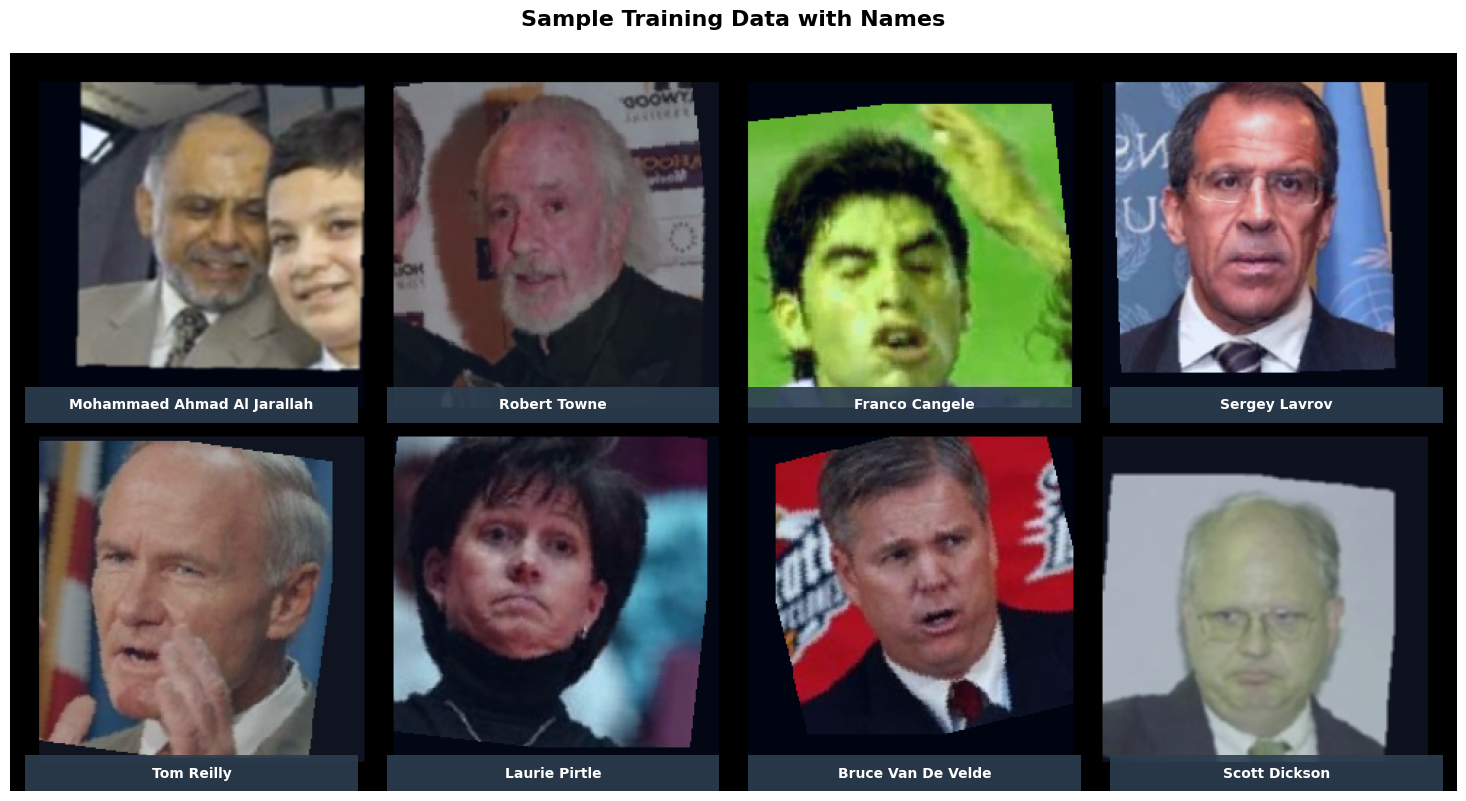

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


  0%|          | 0.00/107M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 162MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s]



Training FaceNet_ResNet50
Visualizing FaceNet_ResNet50 architecture


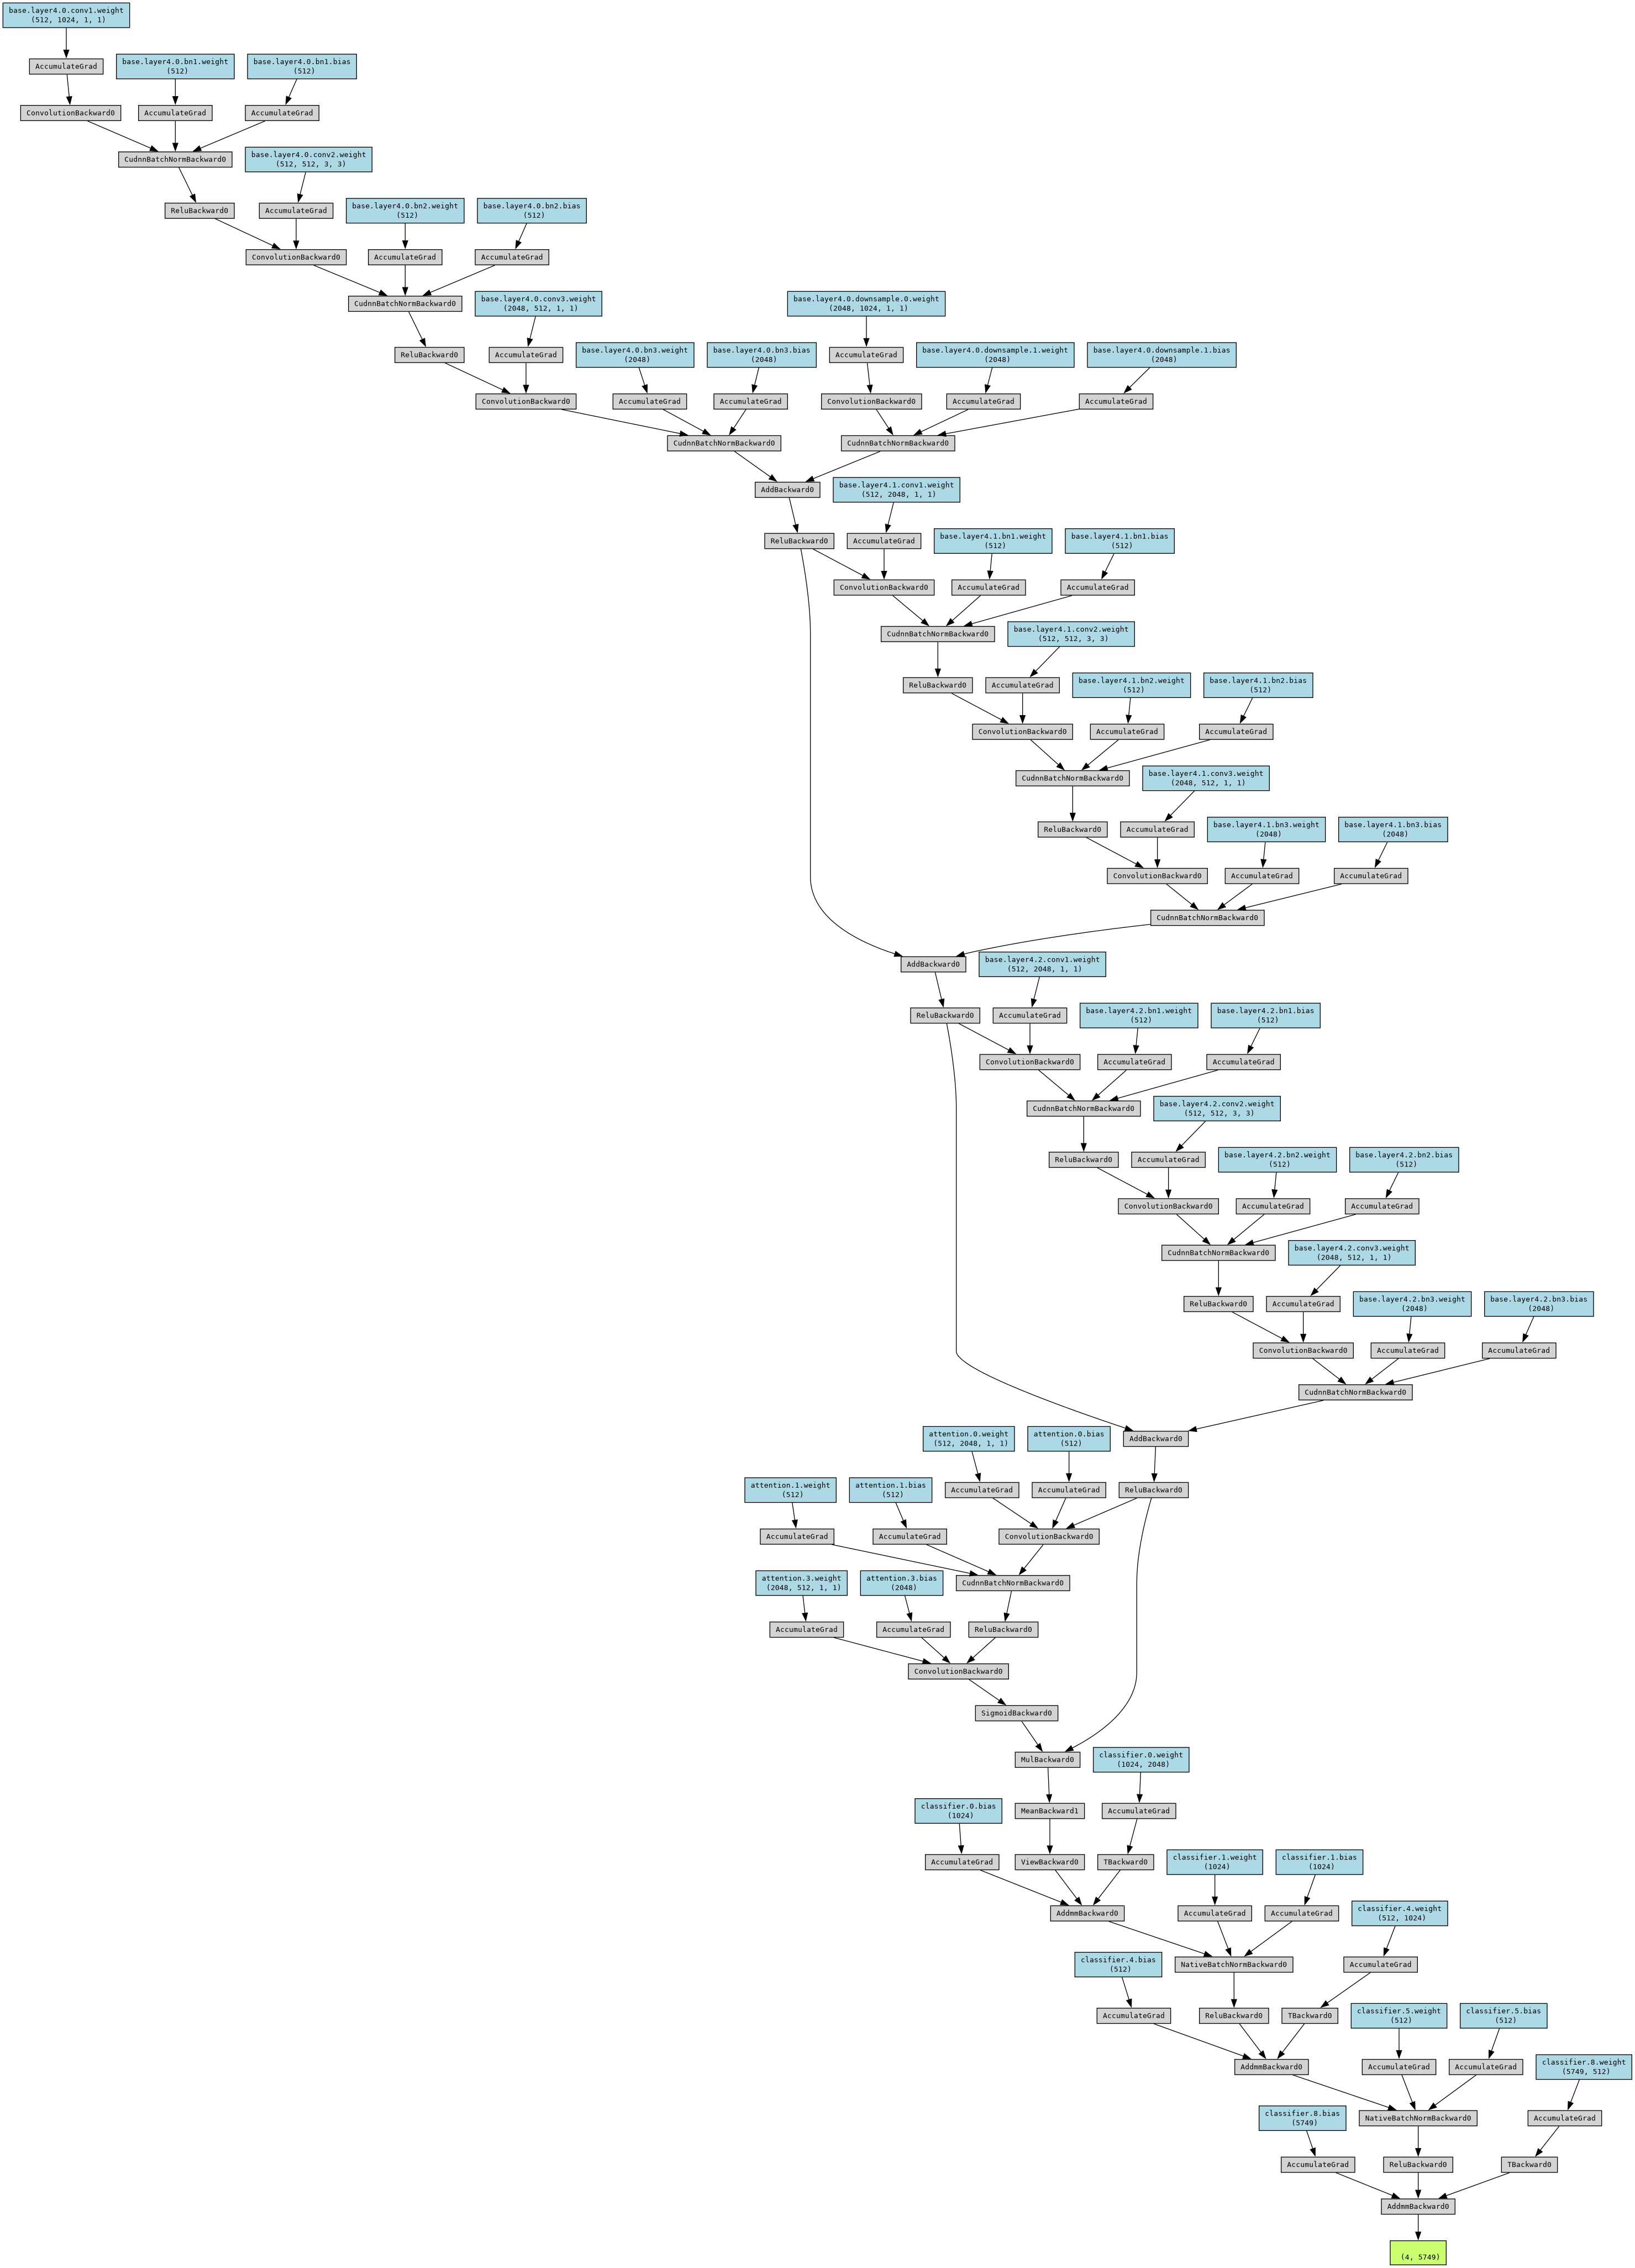

Epoch [1/120]
Train Loss: 9.0555, Train Acc: 1.70%
Val Loss: 8.0464, Val Acc: 7.42%
Epoch [2/120]
Train Loss: 8.2240, Train Acc: 6.07%
Val Loss: 7.4778, Val Acc: 10.34%
Epoch [3/120]
Train Loss: 7.9625, Train Acc: 7.50%
Val Loss: 7.2110, Val Acc: 11.11%
Epoch [4/120]
Train Loss: 7.7100, Train Acc: 9.08%
Val Loss: 7.4967, Val Acc: 11.34%
Epoch [5/120]
Train Loss: 7.4474, Train Acc: 10.48%
Val Loss: 6.8657, Val Acc: 13.34%
Epoch [6/120]
Train Loss: 7.1566, Train Acc: 11.81%
Val Loss: 6.7911, Val Acc: 14.45%
Epoch [7/120]
Train Loss: 7.3278, Train Acc: 7.08%
Val Loss: 10.0315, Val Acc: 12.61%
Epoch [8/120]
Train Loss: 7.1888, Train Acc: 6.67%
Val Loss: 6.7853, Val Acc: 15.03%
Epoch [9/120]
Train Loss: 7.0497, Train Acc: 8.07%
Val Loss: 6.9919, Val Acc: 15.64%
Epoch [10/120]
Train Loss: 6.8961, Train Acc: 8.62%
Val Loss: 6.7474, Val Acc: 17.26%
Epoch [11/120]
Train Loss: 6.7959, Train Acc: 8.85%
Val Loss: 6.5336, Val Acc: 19.06%
Epoch [12/120]
Train Loss: 6.7075, Train Acc: 9.27%
Val Loss:

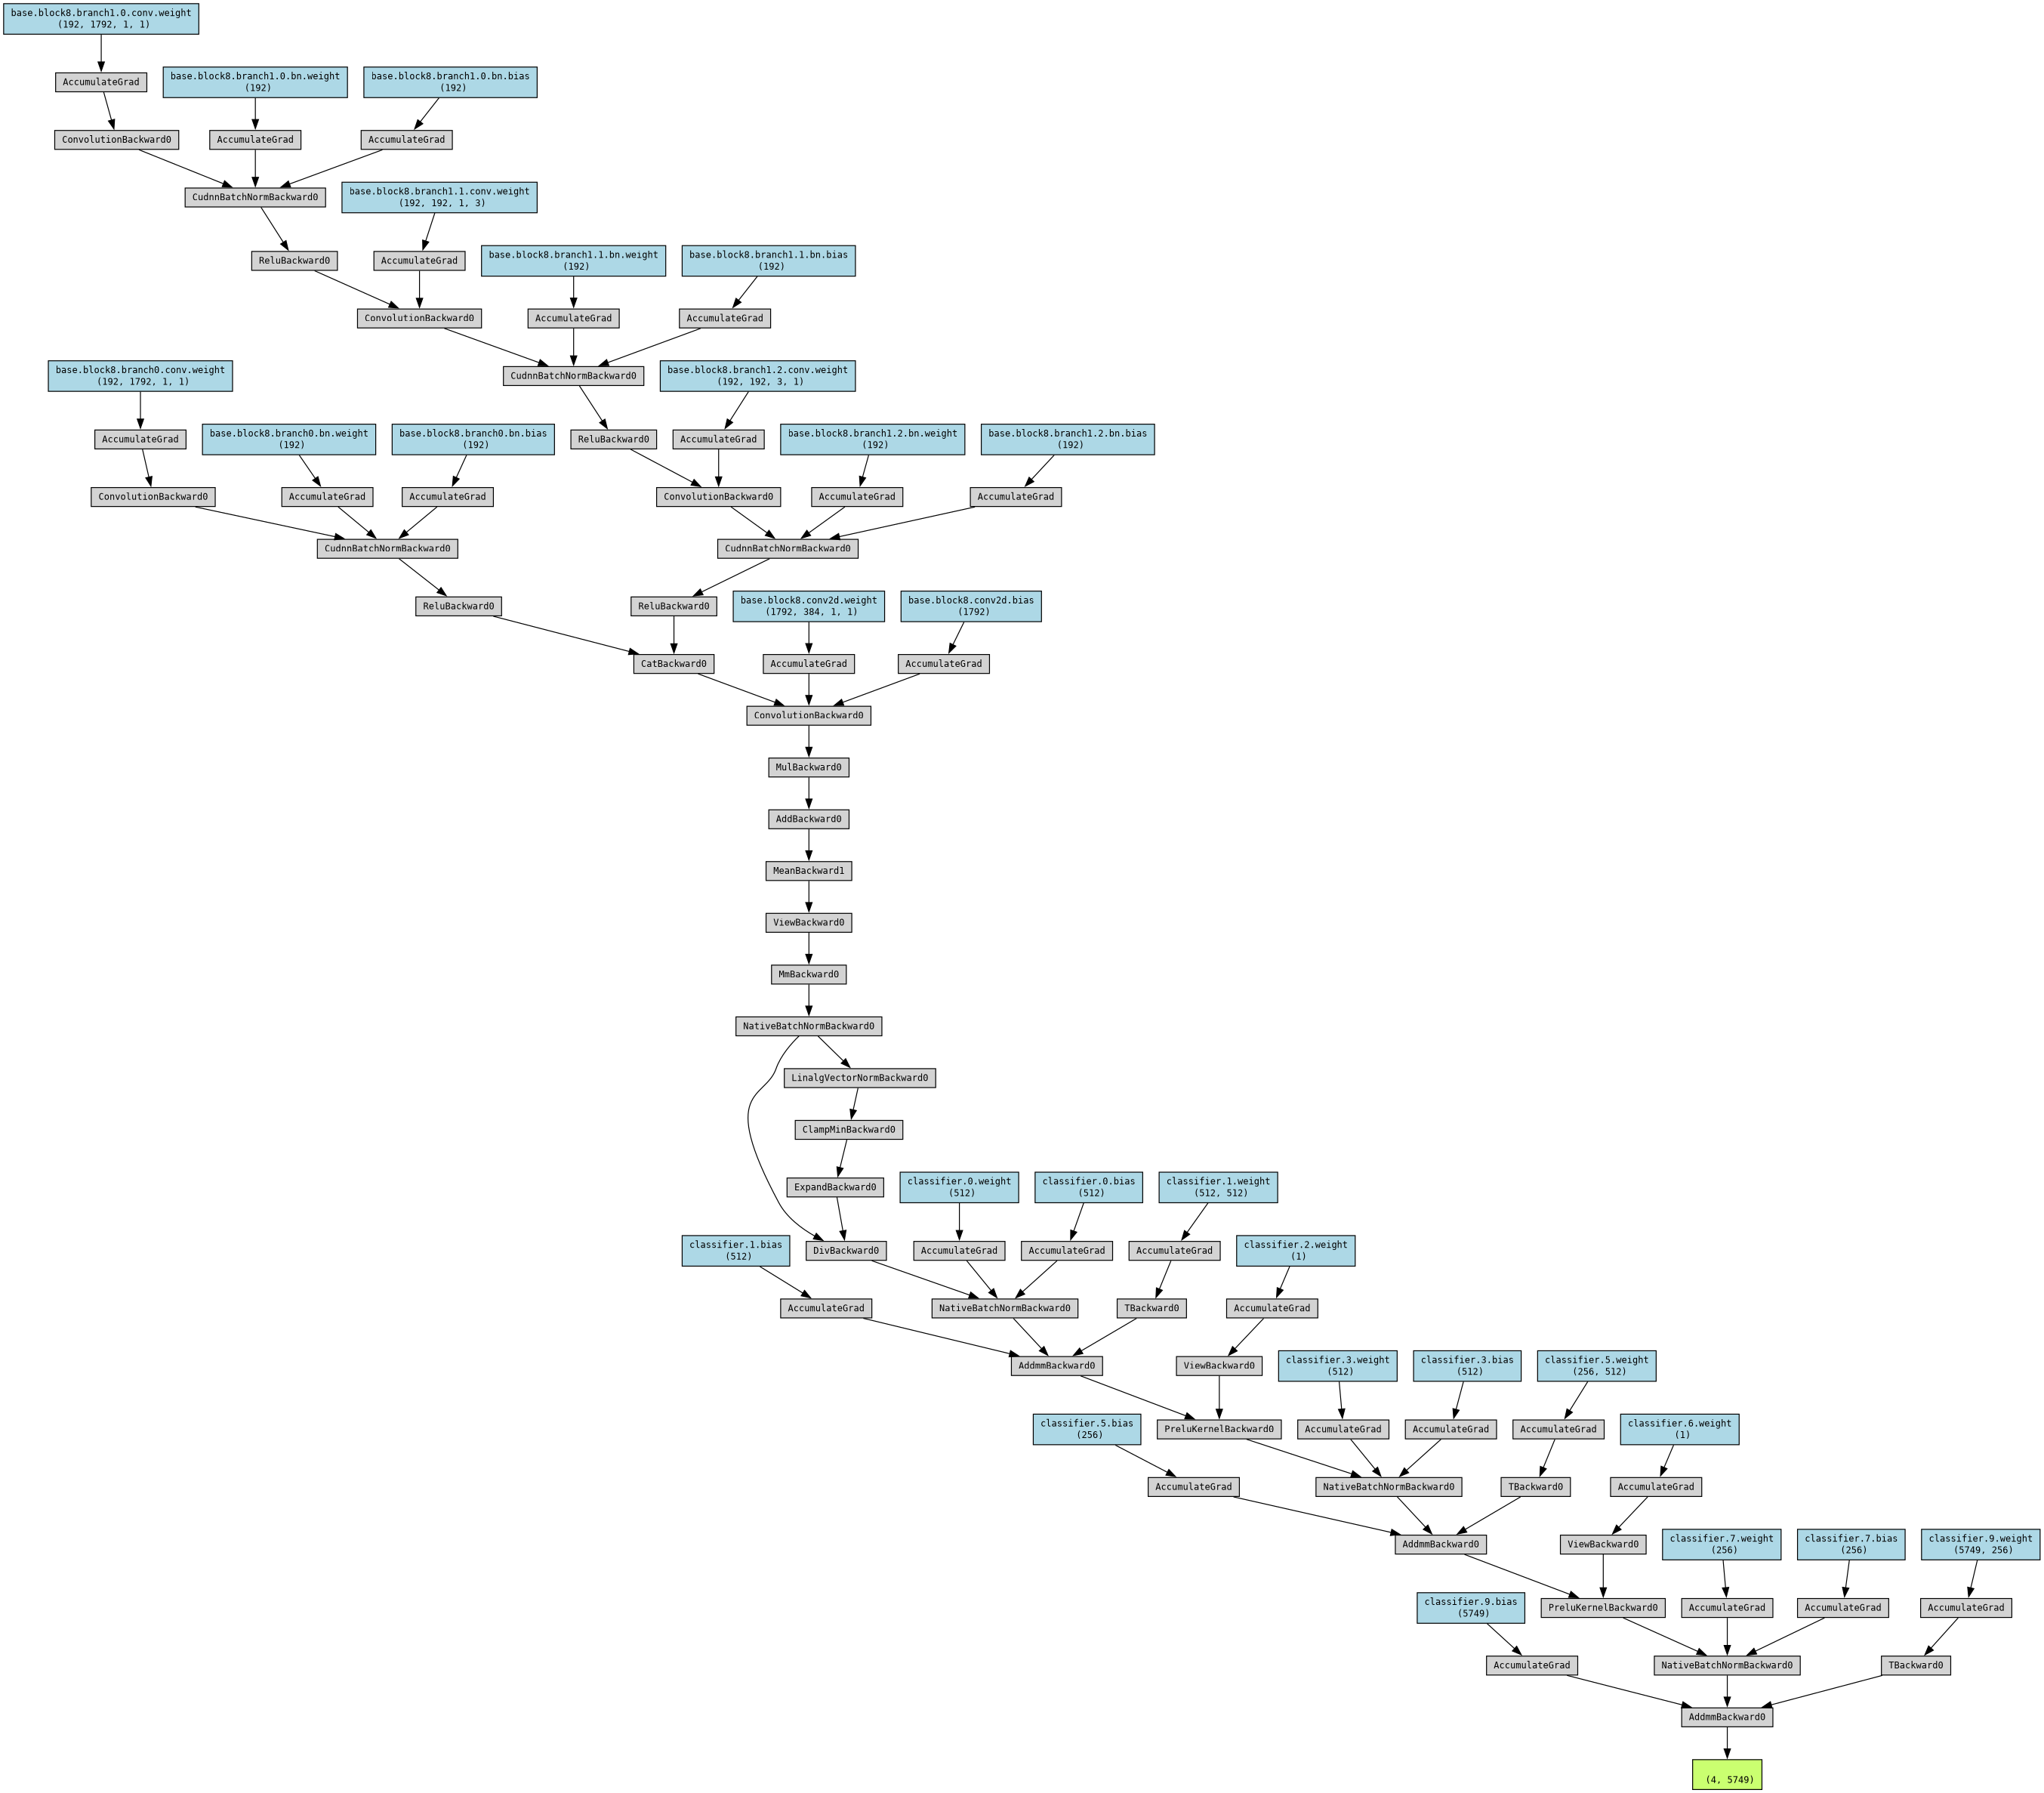

Epoch [1/120]
Train Loss: 10.0305, Train Acc: 0.87%
Val Loss: 8.3680, Val Acc: 6.96%
Epoch [2/120]
Train Loss: 9.2651, Train Acc: 5.50%
Val Loss: 7.7208, Val Acc: 12.76%
Epoch [3/120]
Train Loss: 8.5925, Train Acc: 9.56%
Val Loss: 7.1715, Val Acc: 16.91%
Epoch [4/120]
Train Loss: 8.0261, Train Acc: 12.63%
Val Loss: 6.7057, Val Acc: 20.10%
Epoch [5/120]
Train Loss: 7.5453, Train Acc: 15.01%
Val Loss: 6.3323, Val Acc: 23.67%
Epoch [6/120]
Train Loss: 7.1413, Train Acc: 17.39%
Val Loss: 5.9600, Val Acc: 26.21%
Epoch [7/120]
Train Loss: 7.4771, Train Acc: 9.52%
Val Loss: 5.6388, Val Acc: 29.40%
Epoch [8/120]
Train Loss: 7.2477, Train Acc: 10.05%
Val Loss: 5.4172, Val Acc: 31.86%
Epoch [9/120]
Train Loss: 7.0044, Train Acc: 11.01%
Val Loss: 5.2444, Val Acc: 33.28%
Epoch [10/120]
Train Loss: 6.8513, Train Acc: 12.09%
Val Loss: 5.1541, Val Acc: 33.78%
Epoch [11/120]
Train Loss: 6.7229, Train Acc: 13.63%
Val Loss: 5.0178, Val Acc: 35.47%
Epoch [12/120]
Train Loss: 6.6879, Train Acc: 13.12%
Val

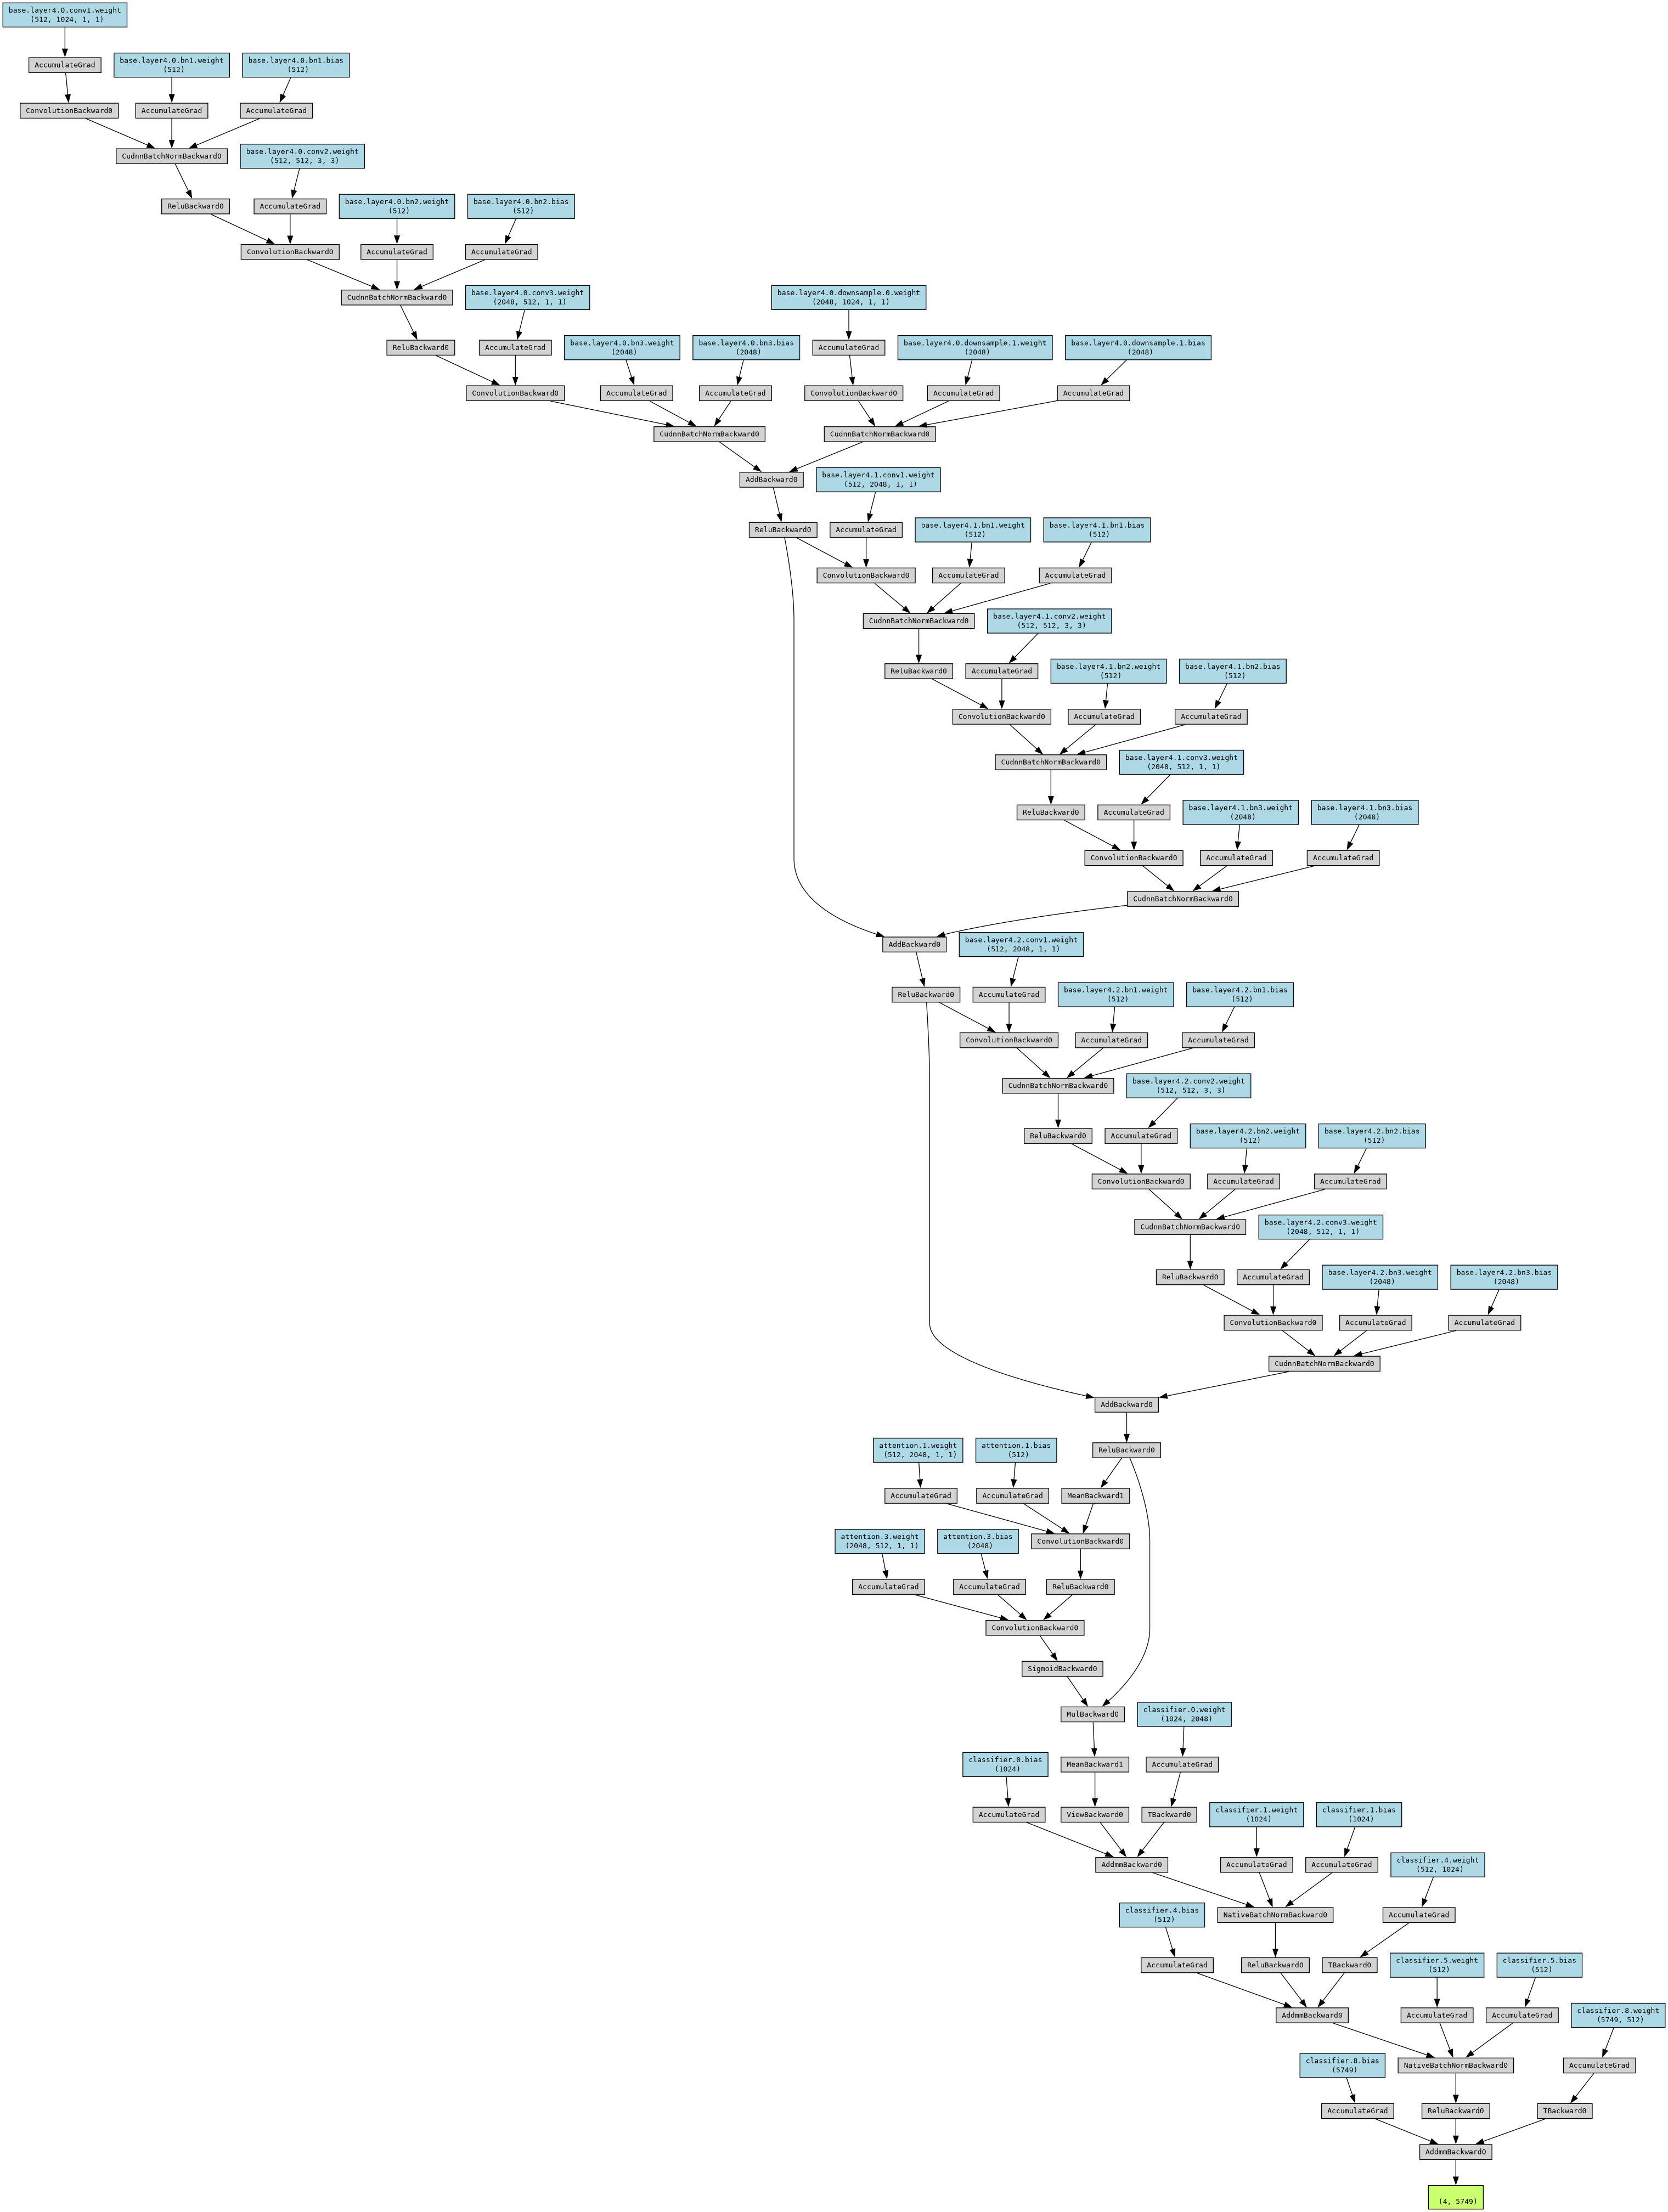

Epoch [1/120]
Train Loss: 9.1104, Train Acc: 1.43%
Val Loss: 7.9002, Val Acc: 7.53%
Epoch [2/120]
Train Loss: 8.3049, Train Acc: 5.53%
Val Loss: 7.6146, Val Acc: 9.88%
Epoch [3/120]
Train Loss: 8.0131, Train Acc: 6.91%
Val Loss: 7.4385, Val Acc: 7.38%
Epoch [4/120]
Train Loss: 7.7442, Train Acc: 8.63%
Val Loss: 7.1015, Val Acc: 13.22%
Epoch [5/120]
Train Loss: 7.4857, Train Acc: 10.02%
Val Loss: 6.8393, Val Acc: 13.14%
Epoch [6/120]
Train Loss: 7.2284, Train Acc: 11.72%
Val Loss: 6.7162, Val Acc: 13.41%
Epoch [7/120]
Train Loss: 7.4464, Train Acc: 7.05%
Val Loss: 7.6237, Val Acc: 12.22%
Epoch [8/120]
Train Loss: 7.3000, Train Acc: 6.85%
Val Loss: 6.4768, Val Acc: 15.49%
Epoch [9/120]
Train Loss: 7.1803, Train Acc: 7.20%
Val Loss: 6.4748, Val Acc: 15.53%
Epoch [10/120]
Train Loss: 7.0735, Train Acc: 7.87%
Val Loss: 6.9720, Val Acc: 17.06%
Epoch [11/120]
Train Loss: 6.8515, Train Acc: 8.19%
Val Loss: 6.0989, Val Acc: 18.22%
Epoch [12/120]
Train Loss: 6.7929, Train Acc: 7.72%
Val Loss: 6.

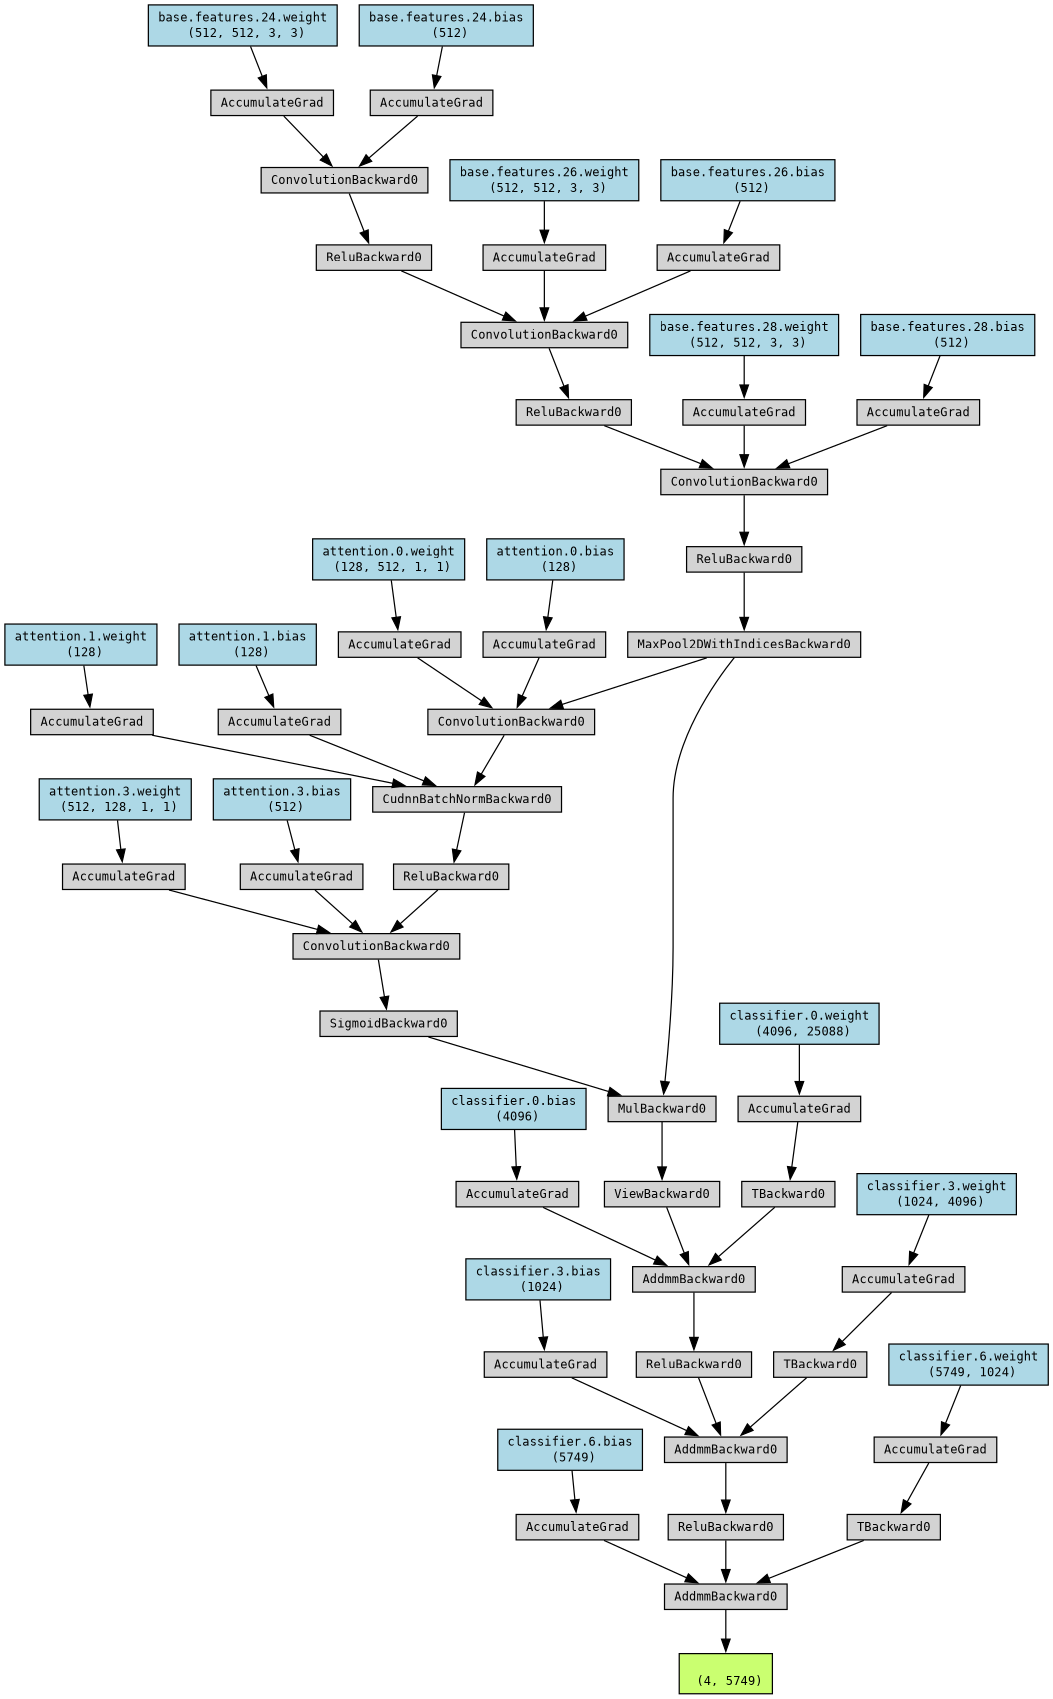

Epoch [1/120]
Train Loss: 8.4719, Train Acc: 3.36%
Val Loss: 7.9436, Val Acc: 5.27%
Epoch [2/120]
Train Loss: 7.9925, Train Acc: 4.42%
Val Loss: 7.6543, Val Acc: 6.15%
Epoch [3/120]
Train Loss: 7.8456, Train Acc: 6.32%
Val Loss: 7.5182, Val Acc: 8.19%
Epoch [4/120]
Train Loss: 7.7013, Train Acc: 7.50%
Val Loss: 7.3635, Val Acc: 9.22%
Epoch [5/120]
Train Loss: 7.5685, Train Acc: 8.80%
Val Loss: 7.1605, Val Acc: 11.76%
Epoch [6/120]
Train Loss: 7.4210, Train Acc: 10.11%
Val Loss: 7.0786, Val Acc: 11.84%
Epoch [7/120]
Train Loss: 7.5400, Train Acc: 6.32%
Val Loss: 6.9033, Val Acc: 12.68%
Epoch [8/120]
Train Loss: 7.4407, Train Acc: 6.66%
Val Loss: 6.8525, Val Acc: 13.60%
Epoch [9/120]
Train Loss: 7.3912, Train Acc: 6.70%
Val Loss: 6.7383, Val Acc: 13.87%
Epoch [10/120]
Train Loss: 7.3018, Train Acc: 6.67%
Val Loss: 6.6639, Val Acc: 14.03%
Epoch [11/120]
Train Loss: 7.2446, Train Acc: 7.31%
Val Loss: 6.6524, Val Acc: 14.60%
Epoch [12/120]
Train Loss: 7.1842, Train Acc: 7.27%
Val Loss: 6.46

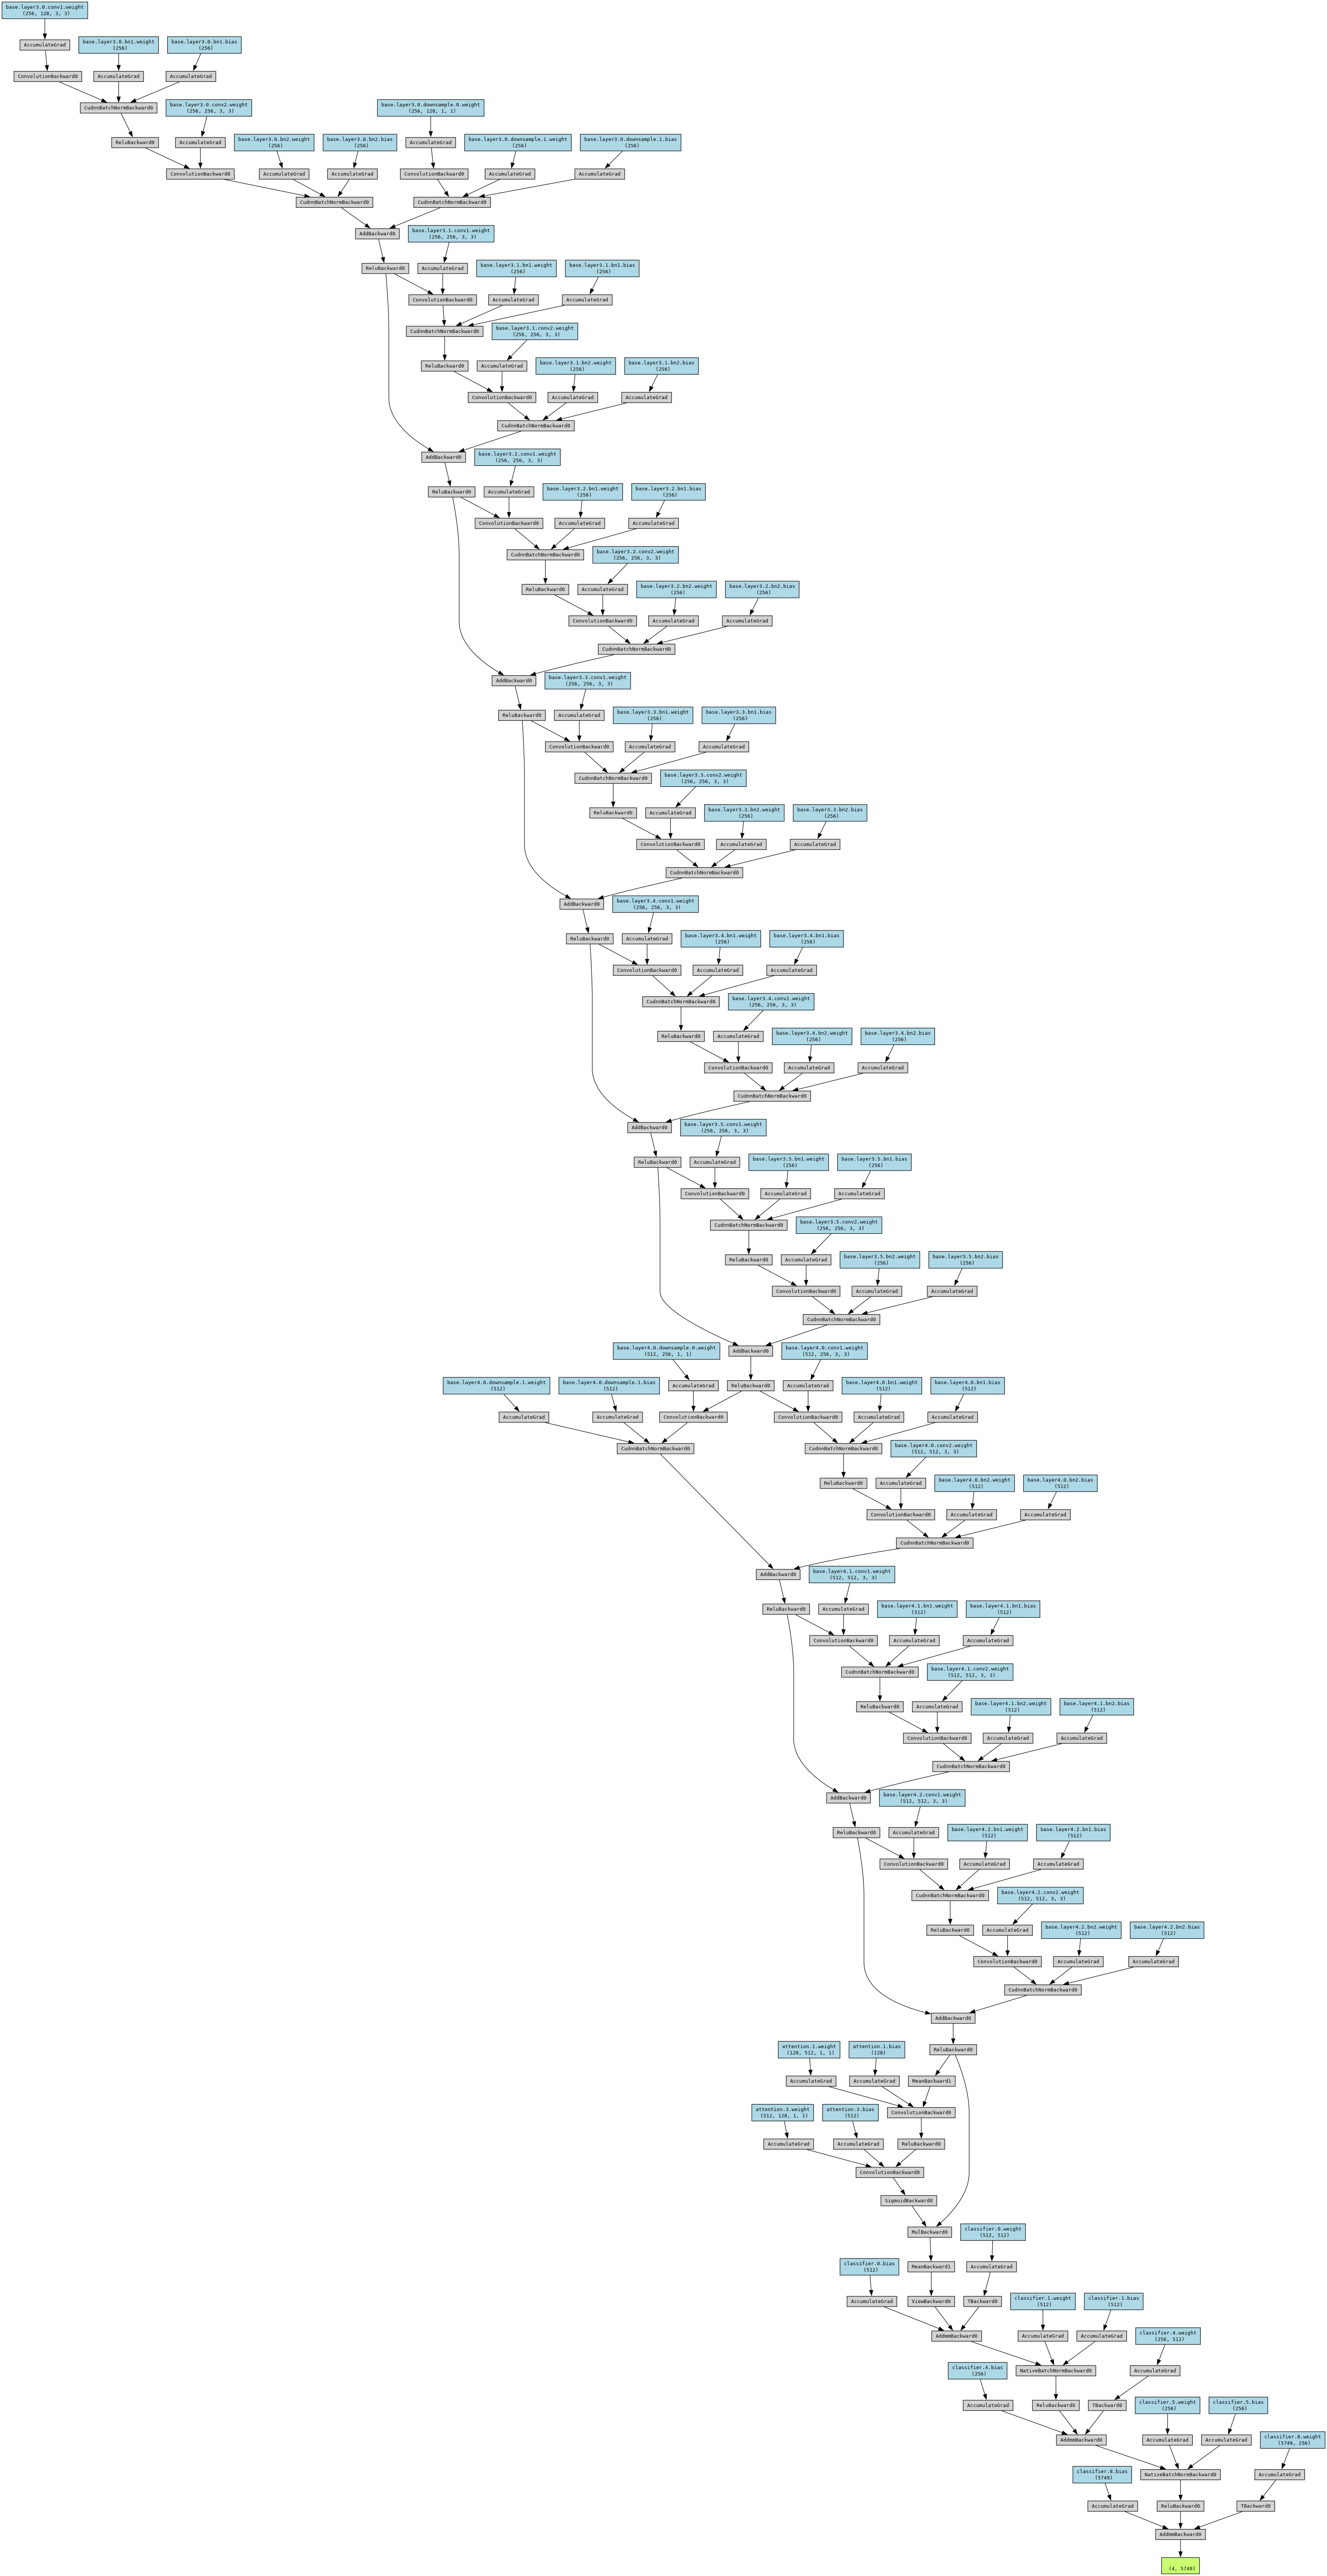

Epoch [1/120]
Train Loss: 9.2106, Train Acc: 0.84%
Val Loss: 8.1959, Val Acc: 5.53%
Epoch [2/120]
Train Loss: 8.5108, Train Acc: 4.19%
Val Loss: 8.0873, Val Acc: 7.61%
Epoch [3/120]
Train Loss: 8.1438, Train Acc: 5.71%
Val Loss: 7.5937, Val Acc: 9.42%
Epoch [4/120]
Train Loss: 7.9332, Train Acc: 6.56%
Val Loss: 7.5219, Val Acc: 10.30%
Epoch [5/120]
Train Loss: 7.7875, Train Acc: 7.97%
Val Loss: 7.2128, Val Acc: 9.99%
Epoch [6/120]
Train Loss: 7.5897, Train Acc: 8.91%
Val Loss: 7.1131, Val Acc: 10.91%
Epoch [7/120]
Train Loss: 7.6592, Train Acc: 5.87%
Val Loss: 6.8591, Val Acc: 12.26%
Epoch [8/120]
Train Loss: 7.5798, Train Acc: 6.16%
Val Loss: 6.8041, Val Acc: 11.95%
Epoch [9/120]
Train Loss: 7.5081, Train Acc: 5.71%
Val Loss: 6.7927, Val Acc: 12.22%
Epoch [10/120]
Train Loss: 7.4340, Train Acc: 6.62%
Val Loss: 6.8143, Val Acc: 12.91%
Epoch [11/120]
Train Loss: 7.3576, Train Acc: 6.51%
Val Loss: 6.5926, Val Acc: 13.72%
Epoch [12/120]
Train Loss: 7.3001, Train Acc: 6.57%
Val Loss: 6.442

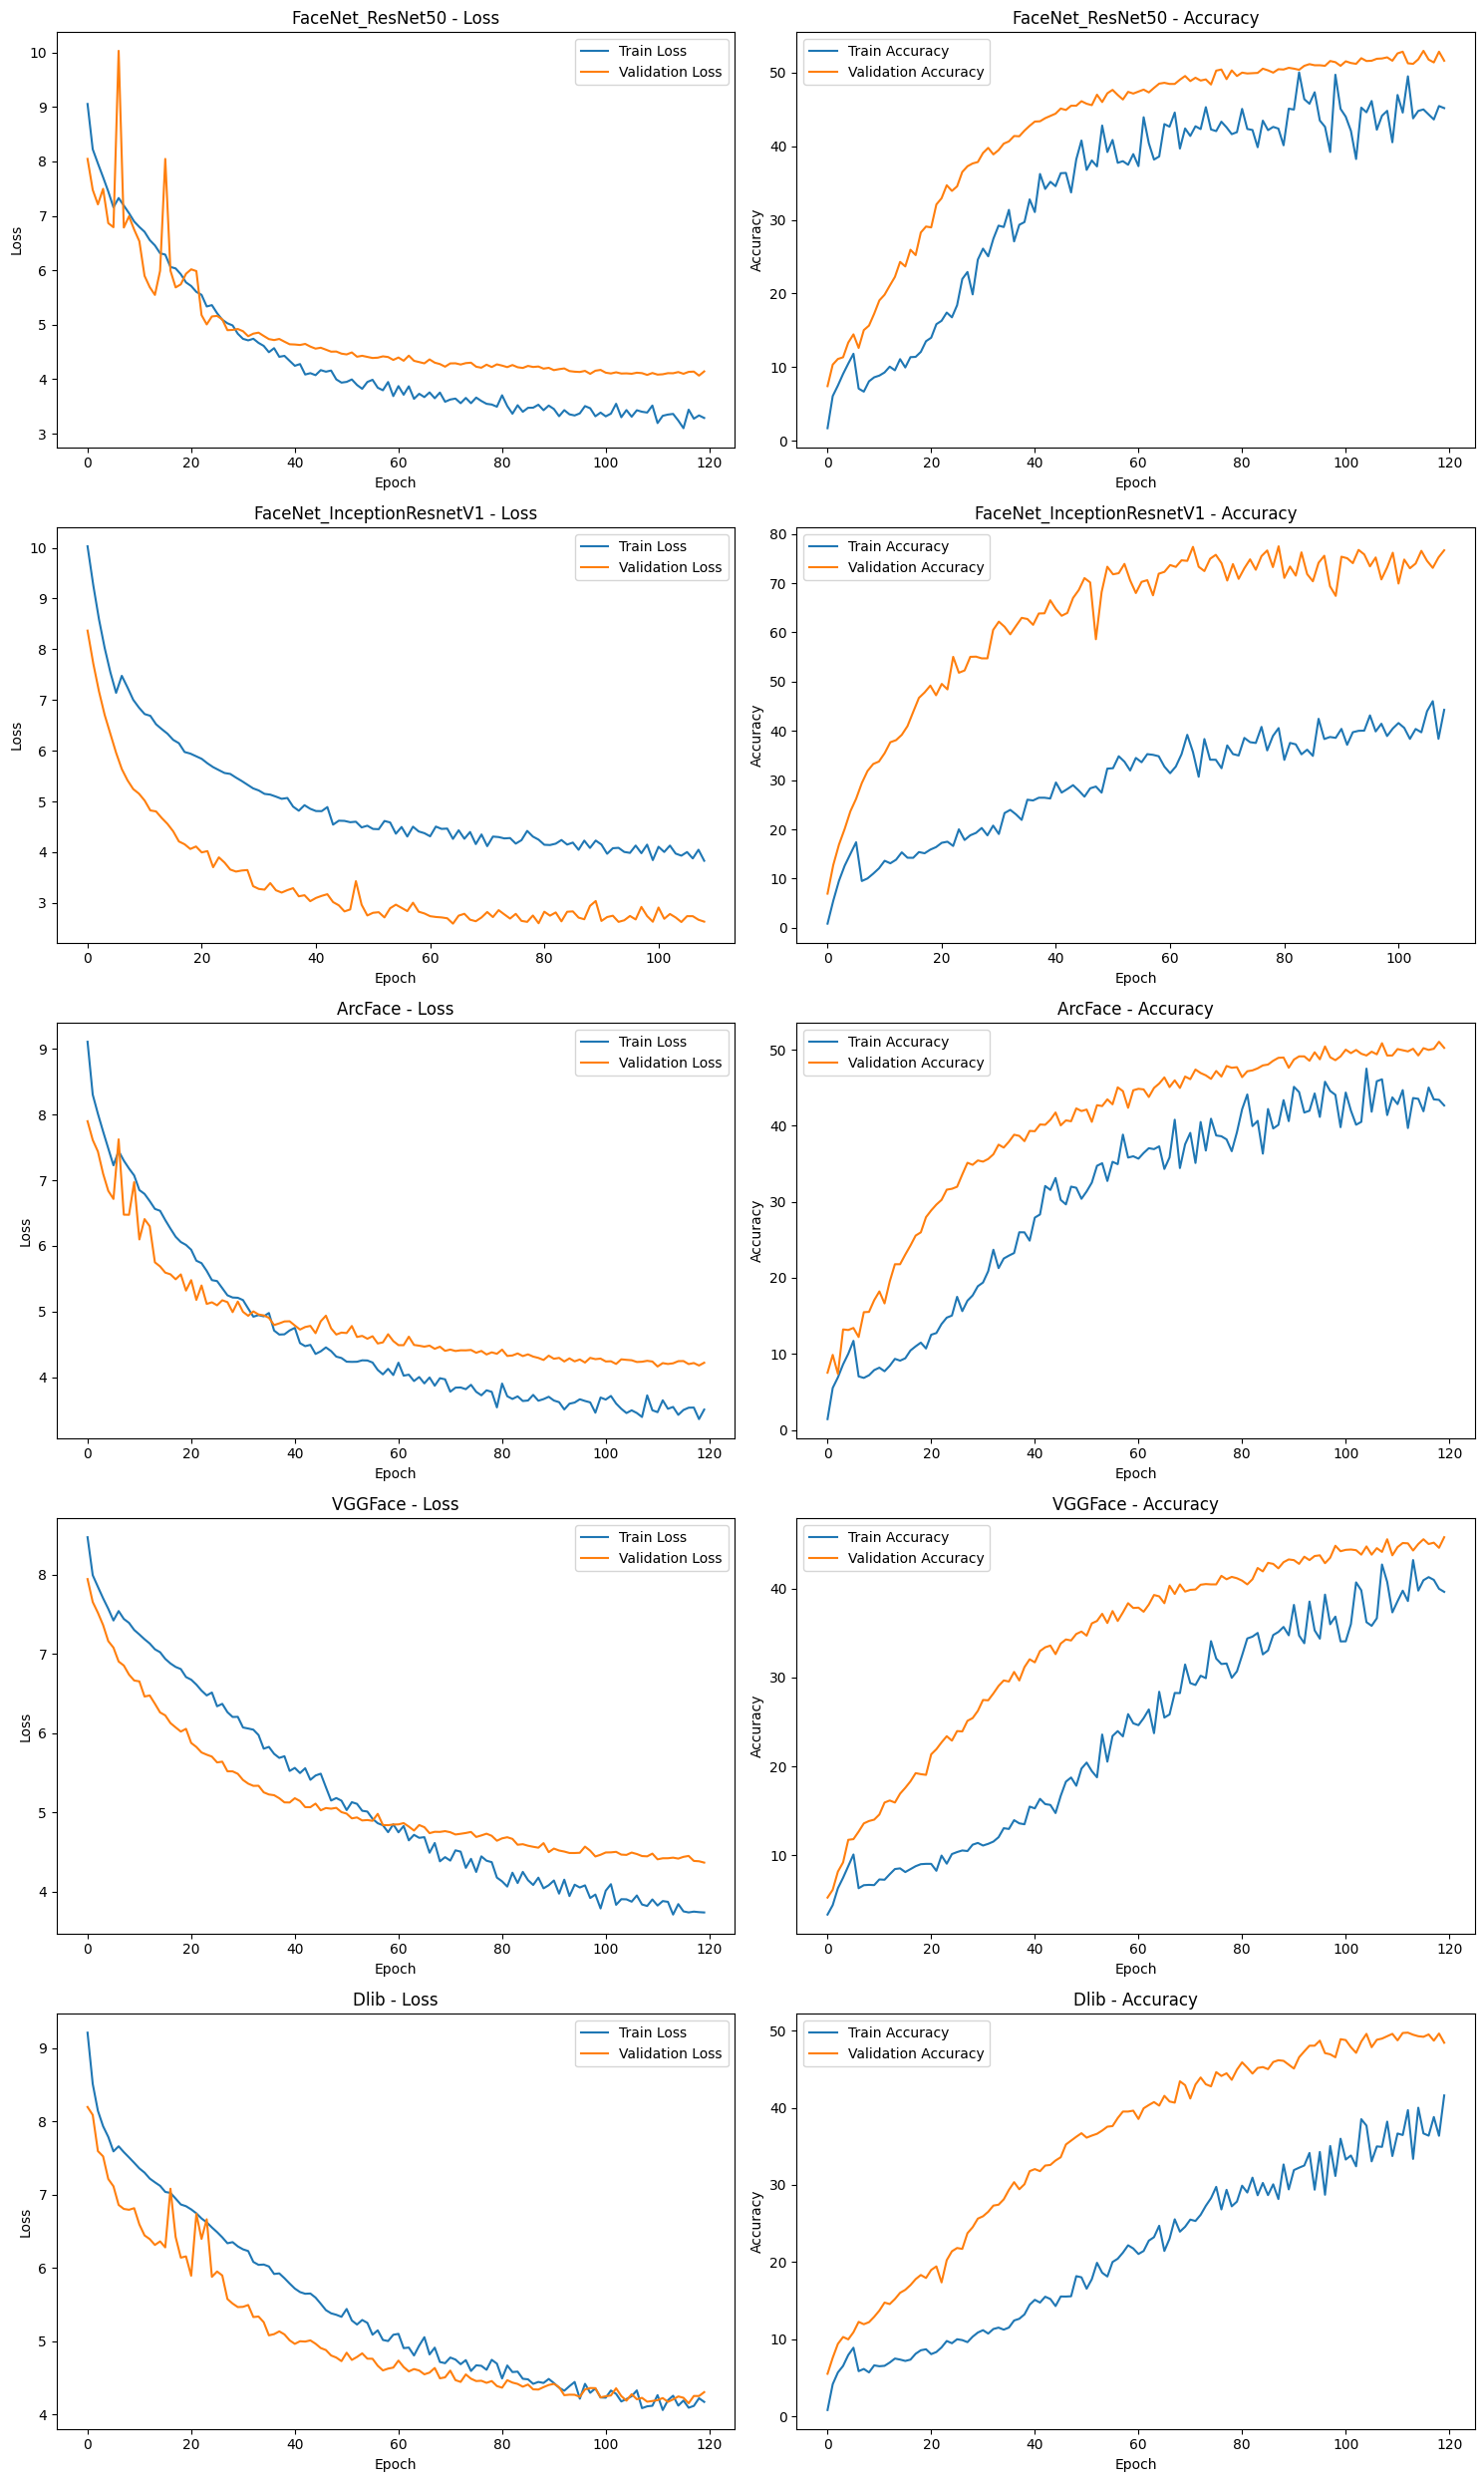

In [13]:
def main():
    print("Setting up Dlib models...")
    setup_dlib_models()
    
    print("Preparing datasets...")
    train_loader, val_loader, num_classes = prepare_data()
    
    models_config = {
        'FaceNet_ResNet50': {
            'model': FaceNetModel(num_classes),
            'criterion': SmoothCrossEntropyLoss(smoothing=0.1),
            'lr': 0.0003,
            'weight_decay': 0.01
        },
        'FaceNet_InceptionResnetV1': {
            'model': ImprovedFaceNet(num_classes),
            'criterion': SmoothCrossEntropyLoss(smoothing=0.1),
            'lr': 0.0003,
            'weight_decay': 0.01
        },
        'ArcFace': {
            'model': ArcFaceModel(num_classes),
            'criterion': SmoothCrossEntropyLoss(smoothing=0.1),
            'lr': 0.0003,
            'weight_decay': 0.01
        },
        'VGGFace': {
            'model': VGGFaceModel(num_classes),
            'criterion': SmoothCrossEntropyLoss(smoothing=0.1),
            'lr': 0.0002,  # Slightly lower learning rate for VGG
            'weight_decay': 0.01
        },
        'Dlib': {
            'model': DlibFaceModel(num_classes),
            'criterion': SmoothCrossEntropyLoss(smoothing=0.1),
            'lr': 0.0003,
            'weight_decay': 0.01
        }
    }
    
    results = {}
    
    for model_name, config in models_config.items():
        print(f"\nTraining {model_name}")
        model = config['model'].to(device)
        criterion = config['criterion']
        
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay'],
            betas=(0.9, 0.999)
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=22,
            min_lr=1e-6,
            verbose=True
        )
        
        # Visualize model architecture
        print(f"Visualizing {model_name} architecture")
        visualize_model_architecture(model)
        
        history, best_acc = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=120,
            model_name=model_name,
            patience=30
        )
        
        results[model_name] = {
            'history': history,
            'best_acc': best_acc
        }
        
        print(f"{model_name}: Best Validation Accuracy = {best_acc:.4f}")
        
    print("\nModel Comparison Results:")
    for model_name, result in results.items():
        print(f"{model_name}: Best Validation Accuracy = {result['best_acc']:.4f}")
    
    # Plot training progress for all models
    plot_training_progress(results)

if __name__ == "__main__":
    main()

# **Conclusion**

In this notebook, explored and compared the performance of five face recognition models: FaceNet with ResNet50, FaceNet with InceptionResnetV1, ArcFace, VGGFace, and Dlib. By analyzing the validation accuracy and training progress of each model, we were able to identify the most effective architecture for our dataset. These results provide a foundation for selecting models in real-world face recognition applications, where accuracy, complexity, and inference speed are all critical considerations.
